# **Twitter Sentiment Analysis using Spark & Hadoop**

### **Contributors**
- <a href = "https://github.com/ahmedembeddedx">Ahmed</a>
- <a href = "https://github.com/Ibtehaj778">Ibtehaj</a>
- Maira

In [3]:
!pip install pyspark
!pip install spark-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=32aa32d537f59e2c83244dbee746cff8bc9a8658aebdd3d0c259930278a7e56e
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.4/568.4 kB 10.4 MB/s eta 0:00:00


### **Necessary Libraries**

In [119]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import HashingTF, IDF
from pyspark.sql.functions import regexp_replace
from pyspark.sql.types import DoubleType, StringType
from pyspark.ml.feature import StringIndexer

import nltk
nltk.download('wordnet')
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from nltk.stem import WordNetLemmatizer

# Models
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.classification import NaiveBayes
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import VectorAssembler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, accuracy_score, confusion_matrix, classification_report

from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### **Spark Session**

In [5]:
spark = SparkSession.builder \
    .appName("Twitter Analysis") \
    .getOrCreate()

### **Spark DataFrame**

In [83]:
df = spark.read.csv("Sentiment.csv", header=True, inferSchema=True, encoding="UTF-8")

In [84]:
columns_to_keep = ['sentiment', 'sentiment_confidence', 'text']

df = df[columns_to_keep]
df.show(10)

+--------------------+--------------------+--------------------+
|           sentiment|sentiment_confidence|                text|
+--------------------+--------------------+--------------------+
|            Positive|                   1|RT @RobGeorge: Th...|
|             Neutral|                   1|Going on #MSNBC L...|
|            Negative|                   1|@JGreenDC @realDo...|
|            Positive|                   1|RT @WayneDupreeSh...|
|Central Time (US ...|                NULL|                NULL|
|            Positive|                   1|RT @pattonoswalt:...|
|            Negative|                   1|Hey @ChrisChristi...|
|            Negative|                   1|reason comment is...|
|            Positive|                   1|RT @ChuckNellis: ...|
|            Negative|                   1|RT @erinmallorylo...|
+--------------------+--------------------+--------------------+
only showing top 10 rows



In [85]:
df = df.withColumn("sentiment_confidence", df["sentiment_confidence"].cast(DoubleType()))

In [86]:
df.printSchema()

root
 |-- sentiment: string (nullable = true)
 |-- sentiment_confidence: double (nullable = true)
 |-- text: string (nullable = true)



In [87]:
df.count()

16032

In [88]:
min_max_confidence = df.selectExpr("min(sentiment_confidence) as min_confidence", "max(sentiment_confidence) as max_confidence").first()

min_confidence = min_max_confidence.min_confidence
max_confidence = min_max_confidence.max_confidence

print(f"Min. Confidence: {min_confidence}")

Min. Confidence: 0.186


### **Dropping Nulls, Retweets & Duplicate**

In [89]:
df = df.na.drop()
df = df.dropDuplicates()

In [90]:
df = df.filter(~df['text'].startswith('RT'))
df = df.filter(~df['text'].startswith('"RT'))
df = df.filter((df['sentiment_confidence'] > 0.5) & (df['sentiment_confidence'] <= 1))

df.show(5)

+---------+--------------------+--------------------+
|sentiment|sentiment_confidence|                text|
+---------+--------------------+--------------------+
|  Neutral|                 1.0|#GOPDebate consta...|
| Negative|                 1.0|"""@RubinReport: ...|
| Negative|                 1.0|#GOPDebate @JohnK...|
|  Neutral|                 1.0|"Fox News was the...|
| Negative|                 1.0|@realDonaldTrump ...|
+---------+--------------------+--------------------+
only showing top 5 rows



In [91]:
def remove_links_and_at_words(text):
    words = text.split()
    cleaned_words = [word for word in words if '@' not in word and 'http://' not in word and 'https://' not in word]
    return ' '.join(cleaned_words)

remove_links_and_at_words_udf = udf(remove_links_and_at_words, StringType())

df = df.withColumn('text', remove_links_and_at_words_udf(df['text']))

df.show(5)

+---------+--------------------+--------------------+
|sentiment|sentiment_confidence|                text|
+---------+--------------------+--------------------+
|  Neutral|                 1.0|#GOPDebate consta...|
| Negative|                 1.0|Finally got it. T...|
| Negative|                 1.0|#GOPDebate your c...|
|  Neutral|                 1.0|"Fox News was the...|
| Negative|                 1.0|is a breath of fr...|
+---------+--------------------+--------------------+
only showing top 5 rows



In [92]:
df.count()

5403

### **Plotting the Univariate Distribution of Sentiments**

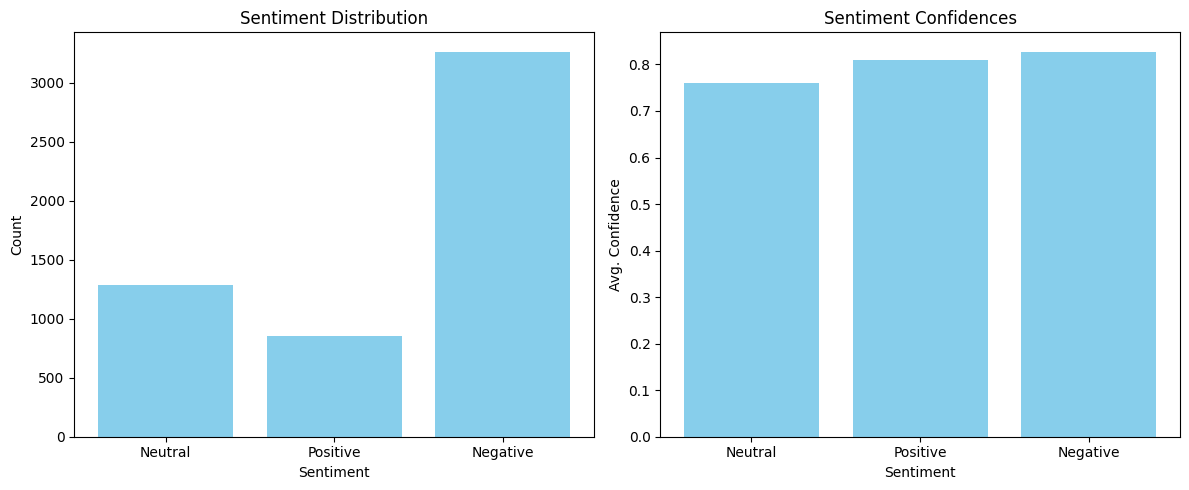

In [93]:
sentiment_counts = df.groupBy('sentiment').count()
sentiment_counts_pd = sentiment_counts.toPandas()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(sentiment_counts_pd['sentiment'], sentiment_counts_pd['count'], color='skyblue')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution')

avg_sentimental_confidence = df.groupBy('sentiment').avg('sentiment_confidence')
sentiment_counts_pd = avg_sentimental_confidence.toPandas()

plt.subplot(1, 2, 2)
plt.bar(sentiment_counts_pd['sentiment'], sentiment_counts_pd['avg(sentiment_confidence)'], color='skyblue')
plt.xlabel('Sentiment')
plt.ylabel('Avg. Confidence')
plt.title('Sentiment Confidences')

plt.tight_layout()
plt.show()

### **Preprocessing <a href = "https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.Pipeline.html">Pipeline</a>**


In [94]:
class Lemmatizer(Transformer):
    def __init__(self, inputCol, outputCol):
        self.inputCol = inputCol
        self.outputCol = outputCol
        self.lemmatizer = WordNetLemmatizer()

    def _transform(self, df):
        lemmatize_udf = udf(lambda tokens: [self.lemmatizer.lemmatize(token) for token in tokens], ArrayType(StringType()))
        return df.withColumn(self.outputCol, lemmatize_udf(df[self.inputCol]))

# Define preprocessing stages
tokenizer = RegexTokenizer(inputCol="text", outputCol="tokens", pattern="\\W")
additional_stop_words = ['gopdebate', 'gopdebates', 'last', 'night', 'candidate', 'candidates']
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens", stopWords=additional_stop_words)
lemmatizer = Lemmatizer(inputCol="filtered_tokens", outputCol="lemmatized_tokens")
count_vectorizer = CountVectorizer(inputCol="lemmatized_tokens", outputCol="rawFeatures")
idf = IDF(inputCol="rawFeatures", outputCol="features")

pipeline = Pipeline(stages=[tokenizer, stopwords_remover, lemmatizer, count_vectorizer, idf])

pipeline_model = pipeline.fit(df)

preprocessed_df = pipeline_model.transform(df)


In [95]:
df = preprocessed_df.select('sentiment', 'features')

df.show(truncate=False)

+---------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|sentiment|features                                                                                                                                                                                                                                                                                                                                                                                                                                              |
+---------+---------------------------------------------------------------------------------------

### **Word Cloud**

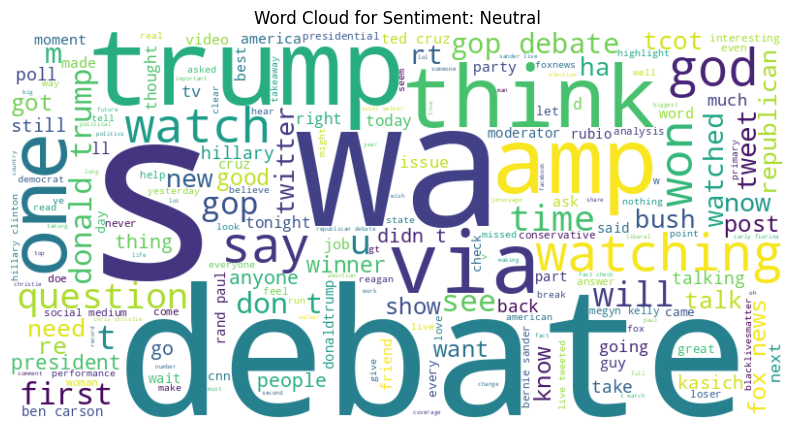

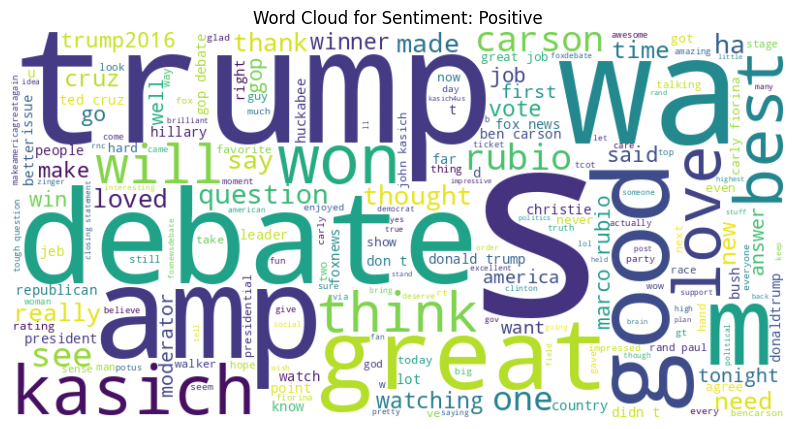

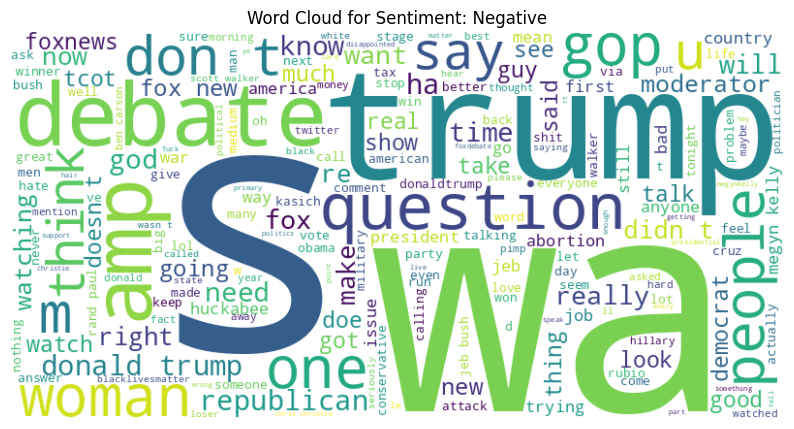

In [96]:
def generate_word_cloud(sentiment_category):
    tokens_by_sentiment = preprocessed_df.filter(preprocessed_df["sentiment"] == sentiment_category).select("lemmatized_tokens")

    lemmatized_tokens = tokens_by_sentiment.rdd.flatMap(lambda x: x[0])

    token_list = lemmatized_tokens.collect()

    text = " ".join(token_list)

    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title("Word Cloud for Sentiment: " + sentiment_category)
    plt.axis("off")
    plt.show()

sentiment_categories = preprocessed_df.select("sentiment").distinct().rdd.flatMap(lambda x: x).collect()
for sentiment_category in sentiment_categories:
    generate_word_cloud(sentiment_category)


### **Label Encoder for Sentiments**

In [97]:
sentiment_indexer = StringIndexer(inputCol="sentiment", outputCol="indexed_sentiment")

indexer_model = sentiment_indexer.fit(df)

df = indexer_model.transform(df)

df.show(5)

+---------+--------------------+-----------------+
|sentiment|            features|indexed_sentiment|
+---------+--------------------+-----------------+
|  Neutral|(7577,[1,2,9,14,1...|              1.0|
| Negative|(7577,[9,10,27,32...|              0.0|
| Negative|(7577,[15,62,96,1...|              0.0|
|  Neutral|(7577,[0,2,4,9,16...|              1.0|
| Negative|(7577,[0,1,2,4,5,...|              0.0|
+---------+--------------------+-----------------+
only showing top 5 rows



In [113]:
df.printSchema()

root
 |-- sentiment: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- indexed_sentiment: double (nullable = false)



### **Applying <a href = "https://spark.apache.org/docs/2.1.0/ml-classification-regression.html#logistic-regression">Logistic Regression</a>**

Accuracy: 0.5819672131147541
Precision: 0.6173878273196621


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


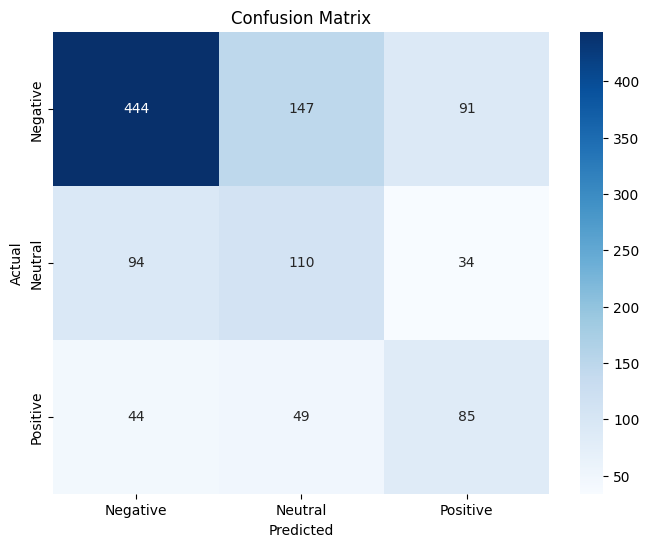

In [99]:
lr = LogisticRegression(featuresCol='features', labelCol='indexed_sentiment')

train_df, test_df = df.randomSplit([0.8, 0.2], seed=69)

lr_model = lr.fit(train_df)

predictions = lr_model.transform(test_df)

accuracy_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_sentiment", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)
log_acc = accuracy
print("Accuracy:", accuracy)

precision_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_sentiment", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)
log_prec = precision
print("Precision:", precision)

prediction_and_label = predictions.select("prediction", "indexed_sentiment").rdd.map(tuple)

metrics = MulticlassMetrics(prediction_and_label)

confusion_matrix = metrics.confusionMatrix().toArray()

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### **Applying <a href = "https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.classification.LogisticRegressionWithSGD.html">Logistic Regression with SGD</a>**

Accuracy: 0.6411657559198543
Precision: 0.6331255936739081


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


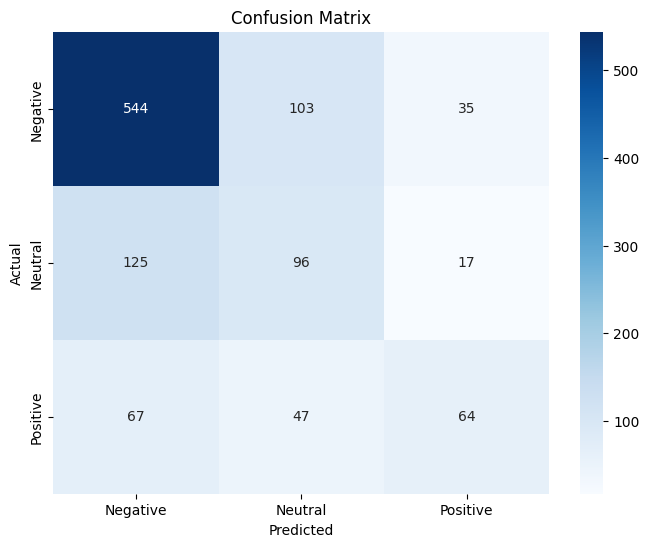

In [22]:

lr = LogisticRegression(featuresCol='features', labelCol='indexed_sentiment',maxIter=100, regParam=0.01, elasticNetParam=0)

train_df, test_df = df.randomSplit([0.8, 0.2], seed=69)

lr_model = lr.fit(train_df)

predictions = lr_model.transform(test_df)

accuracy_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_sentiment", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)
log_acc = accuracy
print("Accuracy:", accuracy)

precision_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_sentiment", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)
log_prec = precision
print("Precision:", precision)

prediction_and_label = predictions.select("prediction", "indexed_sentiment").rdd.map(tuple)

metrics = MulticlassMetrics(prediction_and_label)

confusion_matrix = metrics.confusionMatrix().toArray()

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### **Applying <a href = "https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.regression.LinearRegression.html">Linear Regression</a> 💀**

Root Mean Squared Error (RMSE): 2.1464080946175903
R-squared value: 0.9740642244153709
Mean Absolute Error (MAE): 1.5915481504806965


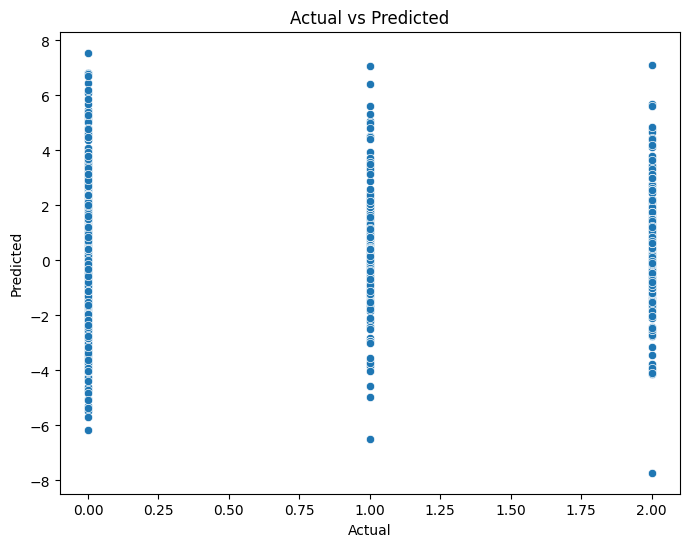

In [110]:

lr = LinearRegression(featuresCol='features', labelCol='indexed_sentiment')

train_df, test_df = df.randomSplit([0.8, 0.2], seed=62)

lr_model = lr.fit(train_df)

predictions = lr_model.transform(test_df)

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="indexed_sentiment", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE):", rmse)

r_squared = lr_model.summary.r2
print("R-squared value:", r_squared)

predictions = lr_model.transform(test_df)

evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="indexed_sentiment", metricName="mae")
mae = evaluator.evaluate(predictions)

print("Mean Absolute Error (MAE):", mae)

pred_and_label = predictions.select("prediction", "indexed_sentiment").toPandas()
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pred_and_label, x="indexed_sentiment", y="prediction")
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

### **Applying <a href = "https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.regression.LinearRegressionWithSGD.html">Linear Regression with SGD</a>**

In [ ]:

labeled_points_rdd = df.rdd.map(lambda row: LabeledPoint(row['indexed_sentiment'], Vectors.dense(row['features'])))

train_data, test_data = labeled_points_rdd.randomSplit([0.8, 0.2], seed=123)

model = LinearRegressionWithSGD.train(train_data, iterations=100, step=0.01)

predictions_and_labels = test_data.map(lambda lp: (float(model.predict(lp.features)), lp.label))
mse = predictions_and_labels.map(lambda p: (p[0] - p[1]) ** 2).mean()
print("Mean Squared Error (MSE) = " + str(mse))

/usr/local/lib/python3.10/dist-packages/pyspark/mllib/regression.py:365: FutureWarning: Deprecated in 2.0.0. Use ml.regression.LinearRegression.
  warnings.warn("Deprecated in 2.0.0. Use ml.regression.LinearRegression.", FutureWarning)


Mean Squared Error (MSE) = 0.7062228330348481


### **Applying <a href = "https://spark.apache.org/docs/2.1.0/ml-classification-regression.html#naive-bayes">Naive Bayes</a>**

Accuracy: 0.5440508628519528
Precision: 0.611363433232508


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


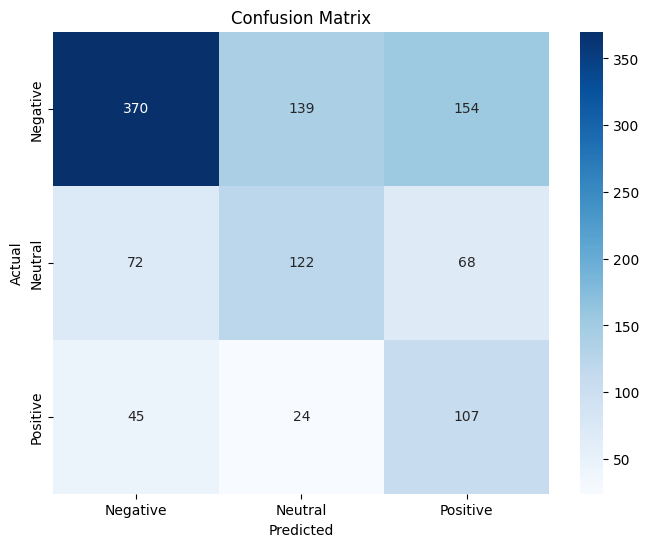

In [108]:
from pyspark.ml.classification import NaiveBayes

nb = NaiveBayes(featuresCol='features', labelCol='indexed_sentiment')


train_df, test_df = df.randomSplit([0.8, 0.2], seed=62)

nb_model = nb.fit(train_df)

predictions = nb_model.transform(test_df)

accuracy_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_sentiment", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

precision_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_sentiment", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)
print("Precision:", precision)

prediction_and_label = predictions.select("prediction", "indexed_sentiment").rdd.map(tuple)

metrics = MulticlassMetrics(prediction_and_label)
confusion_matrix = metrics.confusionMatrix().toArray()

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### **Applying <a href = "https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier">Decision Tree Classifier</a>**

Accuracy: 0.6021798365122616
Precision: 0.5501875095796211


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


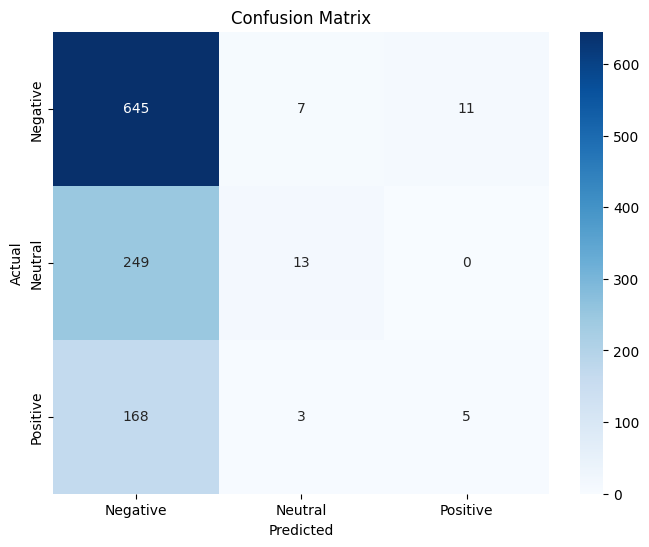

In [104]:
rf = DecisionTreeClassifier(featuresCol='features', labelCol='indexed_sentiment')

train_df, test_df = df.randomSplit([0.8, 0.2], seed=62)

rf_model = rf.fit(train_df)

predictions = rf_model.transform(test_df)

accuracy_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_sentiment", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

precision_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="indexed_sentiment", metricName="weightedPrecision")
precision = precision_evaluator.evaluate(predictions)
print("Precision:", precision)

prediction_and_label = predictions.select("prediction", "indexed_sentiment").rdd.map(tuple)
metrics = MulticlassMetrics(prediction_and_label)
confusion_matrix = metrics.confusionMatrix().toArray()

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


### **Applying <a href = "https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html">KNN</a>**

Accuracy: 0.5827937095282146
Precision: 0.5376638035367556


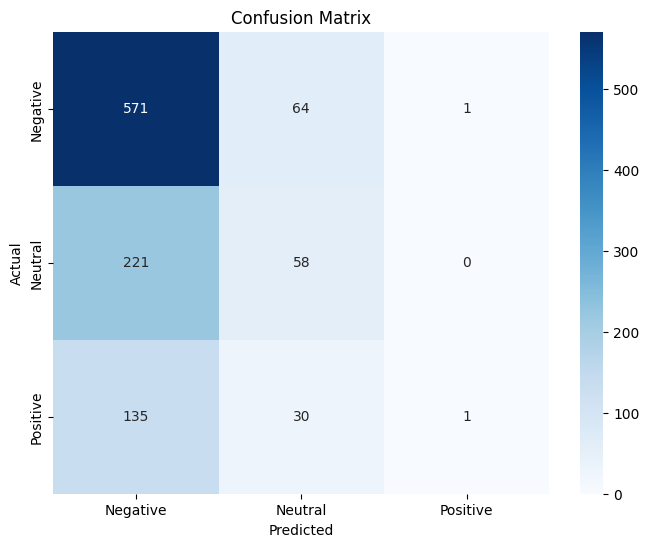

In [120]:

knn = KNeighborsClassifier(n_neighbors=5)

pandas_df = df.select('indexed_sentiment', 'features').toPandas()

X_train, X_test, y_train, y_test = train_test_split(pandas_df['features'], pandas_df['indexed_sentiment'], test_size=0.2, random_state=42)

knn.fit(list(X_train), list(y_train))

y_pred = knn.predict(list(X_test))

precision_weighted = precision_score(y_test, y_pred, average='weighted')

accuracy = accuracy_score(y_test, y_pred)

conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision_weighted)

confusion_matrix = conf_matrix

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues",
            xticklabels=["Negative", "Neutral", "Positive"],
            yticklabels=["Negative", "Neutral", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### **Stop Spark Session**

In [ ]:
spark.stop()

### **Combined Analysis of Metrics**

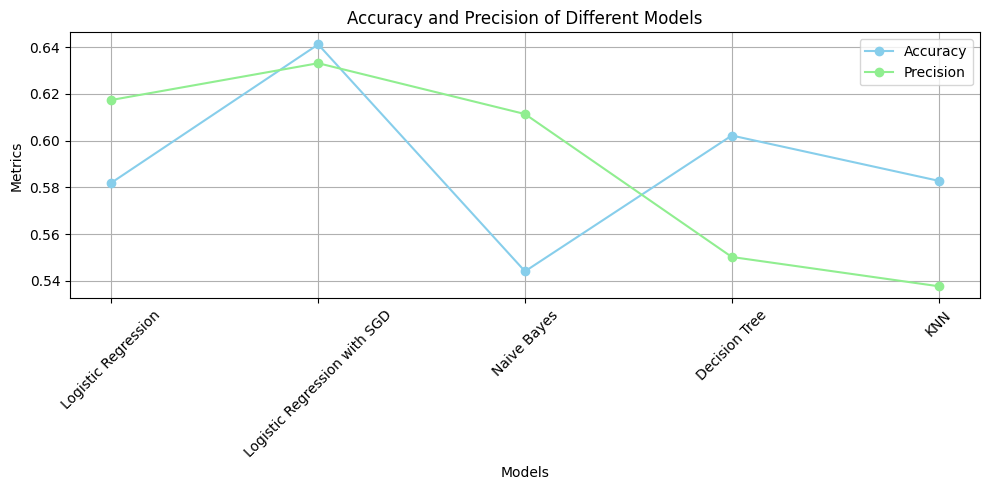

In [1]:
models = ['Logistic Regression', 'Logistic Regression with SGD', 'Naive Bayes',
          'Decision Tree', 'KNN']
accuracy = [0.5819672131147541, 0.6411657559198543, 0.5440508628519528,
            0.6021798365122616, 0.5827937095282146]
precision = [0.6173878273196621, 0.6331255936739081, 0.611363433232508,
             0.5501875095796211, 0.5376638035367556]

plt.figure(figsize=(10, 5))

plt.plot(models, accuracy, marker='o', linestyle='-', color='skyblue', label='Accuracy')
plt.plot(models, precision, marker='o', linestyle='-', color='lightgreen', label='Precision')

plt.title('Accuracy and Precision of Different Models')
plt.xlabel('Models')
plt.ylabel('Metrics')
plt.legend()

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


### **Final Interpretation**

The analysis explores the performance of various machine learning models on a dataset. Logistic regression achieved an accuracy of 58.20% and a precision of 61.74%. When employing logistic regression with stochastic gradient descent (SGD), the accuracy improved to 64.12%, with a precision of 63.31%. Linear regression, though not suitable for classification problems, displayed poor performance, indicated by a high root mean squared error (RMSE) of 2.15, a high R-squared value of 0.97, and a mean absolute error (MAE) of 1.59. Implementing linear regression with SGD yielded a mean squared error (MSE) of 0.71. Naive Bayes achieved an accuracy of 54.41% and a precision of 61.14%, while decision tree classifier and KNN attained accuracies of 60.22% and 58.28%, respectively, with precisions of 55.02% and 53.77%.

The presence of biased data, primarily due to the inclusion of negative entries, impacted model performance. Removing these entries could have resulted in an insufficient dataset size. To select the best model, it's essential to plot accuracy, precision, and other relevant metrics for comparison. Such visualizations would aid in identifying the most suitable model for the given dataset.